<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_3_3_1_Lab_Gradient_descent_for_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Gradient descent for logistic regression

## Imports

In [1]:
!pip install -q ipympl

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

In [3]:
import pandas as pd
import numpy as np
import copy, math

import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.patches import FancyArrowPatch
from matplotlib.widgets import Button

## Toy Dataset

In [4]:
data = pd.DataFrame({
    'x1': [0.5, 1, 1.5, 3, 2, 1],
    'x2': [1.5, 1, 0.5, 0.5, 2, 2.5],
    'y': [0, 0, 0, 1, 1, 1]
})

data

,x1,x2,y
0,0.5,1.5,0
1,1.0,1.0,0
2,1.5,0.5,0
3,3.0,0.5,1
4,2.0,2.0,1
5,1.0,2.5,1


In [5]:
x_train = data.drop('y', axis=1).values
y_train = data['y'].values
x_train, y_train

(array([[0.5, 1.5],
        [1. , 1. ],
        [1.5, 0.5],
        [3. , 0.5],
        [2. , 2. ],
        [1. , 2.5]]),
 array([0, 0, 0, 1, 1, 1]))

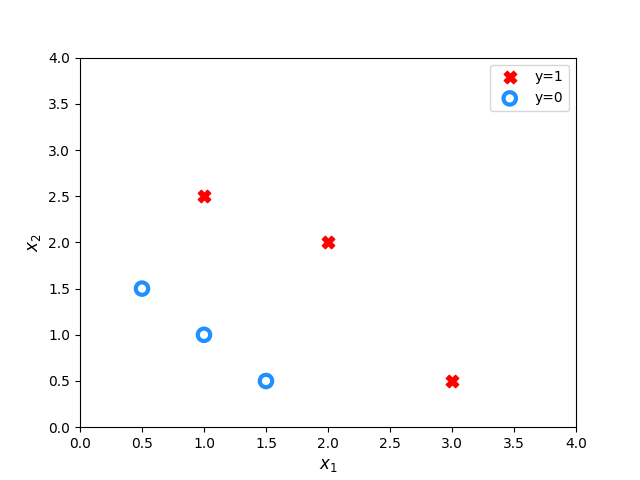

In [6]:
pos = (y_train == 1)
neg = (y_train == 0)

plt.scatter(x_train[pos, 0], x_train[pos, 1],
              marker='X', s=80, c='red', label='y=1')
plt.scatter(x_train[neg, 0], x_train[neg, 1],
              marker='o', s=80, facecolors='none',
              edgecolor='dodgerblue', lw=3, label='y=0')
plt.axis([0, 4, 0, 4])
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.legend()

plt.show()

## Logistic Gradient Descent

### Sigmoid

The sigmoid function (aka logistic function) only has outputs between 0 and 1.

$$
g(z) = \frac{1}{1 + e^{-z}}
$$
<br>
$$
0 \lt g(z) \lt 1
$$

In [7]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

### Prediction

$$
f_{\vec{w},b}\left(\vec{x}\right) = \frac{1}{1 + e^{-(\vec{w}\cdot\vec{x} + b)}}
$$

$$
P(y = 1|\vec{x};\vec{w},b)
$$

In [8]:
def predict_logistic(X, w, b):
    """ performs prediction """
    return sigmoid(X @ w + b)

### Cost Function

$$
J\left(\vec{w},b\right) = -\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}\log{\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right)} + \left(1 - y^{(i)}\right)\log{\left(1 - f_{\vec{w},b}\left(\vec{x}^{(i)}\right)\right)}\right)
$$

In [9]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]

    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        cost += y[i] * np.log(f_wb_i) + (1 - y[i]) * np.log(1 - f_wb_i)

    cost = -(cost / m)

    return cost

### Gradient

$$
\begin{align}
\frac{\partial}{\partial w_j} &= \frac{1}{m}\sum_{i=1}^{m}\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)}\right)x_j^{(i)} \\
\frac{\partial}{\partial b} &= \frac{1}{m}\sum_{i=1}^{m}\left(f_{\vec{w},b}\left(\vec{x}^{(i)}\right) - y^{(i)}\right)
\end{align}
$$

In [10]:
def compute_gradient_logistic(X, y, w, b):
    """
    Computes the gradient for linear regression

    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.0

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]
        dj_db = dj_db + err_i

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

dj_db, dj_dw = compute_gradient_logistic(x_train, y_train, np.array([2.0, 3.0]), 1.0)

dj_db, dj_dw

(0.49861806546328574, array([0.49833339, 0.49883943]))

### Gradient Descent

repeat {
$$
\begin{align}
w_j &= w_j - \alpha \frac{\partial}{\partial w_j}J\left(\vec{w}, b\right) \\
b &= b - \alpha \frac{\partial}{\partial b}J\left(\vec{w}, b\right)
\end{align}
$$
}

In [11]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent

    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter
      J_history (List)   : History of cost values
    """

    J_history = [] # an array of cost values
    w = copy.deepcopy(w_in) # avoid modifying global w within the function
    b = b_in

    for i in range(num_iters):
        # calculate the gradient
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)

        # update the parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # save cost at each iteration
        if i < 100_000: # prevent resource exhaustion
            J_history.append(compute_cost_logistic(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f'Iteration {i:4d}: Cost {J_history[-1]}')

    return w, b, J_history

w_out, b_out, j_hist = gradient_descent(x_train,
                                        y_train,
                                        w_in = np.zeros_like(x_train[0]),
                                        b_in = 0.0,
                                        alpha=0.1,
                                        num_iters=10_000)

Iteration    0: Cost 0.684610468560574
Iteration 1000: Cost 0.1590977666870457
Iteration 2000: Cost 0.08460064176930078
Iteration 3000: Cost 0.05705327279402531
Iteration 4000: Cost 0.04290759421682
Iteration 5000: Cost 0.03433847729884557
Iteration 6000: Cost 0.02860379802212006
Iteration 7000: Cost 0.02450156960879306
Iteration 8000: Cost 0.02142370332569295
Iteration 9000: Cost 0.019030137124109114


In [12]:
w_out, b_out

(array([5.28123029, 5.07815608]), -14.222409982019837)

In [13]:
compute_cost_logistic(x_train, y_train, w_out, b_out)

0.017117768890292925

### Plot the results of gradient descent

In [14]:
def plt_prob(ax, w_out, b_out):
    x0_space = np.linspace(0, 4, 100)
    x1_space = np.linspace(0, 4, 100)

    # get the probability for x0, x1 ranges
    tmp_x0, tmp_x1 = np.meshgrid(x0_space, x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            z[i, j] = sigmoid(
                np.dot(w_out,
                       np.array([tmp_x0[i,j],
                                 tmp_x1[i,j]])) + b_out
            )

    pcm = ax.pcolormesh(tmp_x0,
                        tmp_x1,
                        z,
                        cmap='Blues')
    ax.figure.colorbar(pcm, ax=ax)

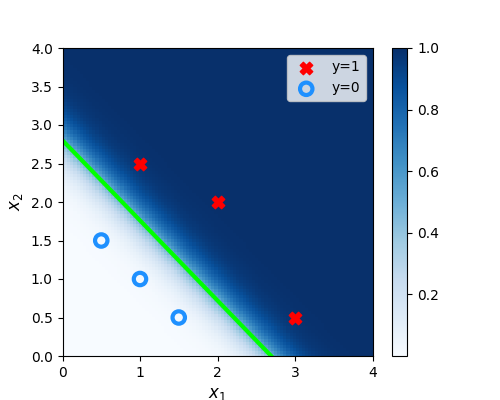

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# plot the probability
plt_prob(ax, w_out, b_out)

# plot the original data
ax.scatter(x_train[pos, 0], x_train[pos, 1],
              marker='X', s=80, c='red', label='y=1')
ax.scatter(x_train[neg, 0], x_train[neg, 1],
              marker='o', s=80, facecolors='none',
              edgecolor='dodgerblue', lw=3, label='y=0')

# plot the decision boundary
# when x1 = 0
x0 = -b_out / w_out[0]
# when x0 = 0
x1 = -b_out / w_out[1]
ax.plot([x0, 0], [0, x1], c='lime', lw=3)

ax.axis([0, 4, 0, 4])
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.legend()

plt.show()

In the plot above:
 - the shading reflects the probability y=1 (result prior to decision boundary)
 - the decision boundary is the line at which the probability = 0.5

### Another Dataset

In [16]:
x_train = np.array([0, 1, 2, 3, 4, 5])
y_train = np.array([0, 0, 0, 1, 1, 1])

In [17]:
pos = (y_train == 1)
neg = (y_train == 0)

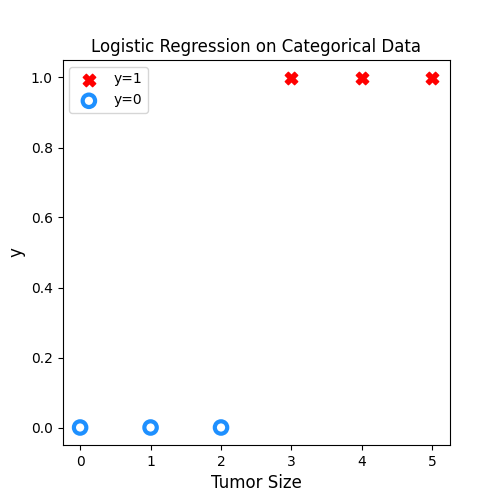

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# plot data1
ax.scatter(x_train[pos], y_train[pos],
              marker='X', s=80, c='red', label='y=1')
ax.scatter(x_train[neg], y_train[neg],
              marker='o', s=80, facecolors='none',
              edgecolor='dodgerblue', lw=3, label='y=0')
ax.set_xlabel('Tumor Size', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Logistic Regression on Categorical Data')
ax.legend()

plt.show()

In the plot below, try:
- changing $w$ and $b$ by clicking within the contour plot on the upper right.
    - changes may take a second or two
    - note the changing value of cost on the upper left plot.
    - note the cost is accumulated by a loss on each example (vertical dotted lines)
- run gradient descent by clicking the orange button.
    - note the steadily decreasing cost (contour and cost plot are in log(cost)
    - clicking in the contour plot will reset the model for a new run
- to reset the plot, rerun the cell

In [19]:
def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost

In [20]:
def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out

In [21]:
def gradient_descent2(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices

    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw                                           # scalar, (n,1)

In [22]:
class data_plot:
    ''' handles data plot '''
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, ax, x_train, y_train, w, b):
        self.ax = ax
        self.x_train = x_train
        self.y_train = y_train
        self.m = x_train.shape[0]
        self.w = w
        self.b = b

        self.plt_tumor_data()
        self.draw_logistic_lines(firsttime=True)
        self.mk_cost_lines(firsttime=True)

        self.ax.autoscale(enable=False) # leave plot scales the same after initial setup

    def plt_tumor_data(self):
        x = self.x_train
        y = self.y_train
        pos = y == 1
        neg = y == 0
        self.ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
        self.ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none',
                   edgecolors='dodgerblue',lw=3)
        self.ax.set_ylim(-0.175,1.1)
        self.ax.set_ylabel('y')
        self.ax.set_xlabel('Tumor Size')
        self.ax.set_title("Logistic Regression on Categorical Data")

    def update(self, w, b):
        self.w = w
        self.b = b
        self.draw_logistic_lines()
        self.mk_cost_lines()

    def draw_logistic_lines(self, firsttime=False):
        if not firsttime:
            self.aline[0].remove()
            self.bline[0].remove()
            self.alegend.remove()

        xlim  = self.ax.get_xlim()
        x_hat = np.linspace(*xlim, 30)
        y_hat = sigmoid(np.dot(x_hat.reshape(-1,1), self.w) + self.b)
        self.aline = self.ax.plot(x_hat, y_hat, color='dodgerblue',
                                     label="y = sigmoid(z)")
        f_wb = np.dot(x_hat.reshape(-1,1), self.w) + self.b
        self.bline = self.ax.plot(x_hat, f_wb, color='orange', lw=1,
                                     label=f"z = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
        self.alegend = self.ax.legend(loc='upper left')

    def mk_cost_lines(self, firsttime=False):
        ''' makes vertical cost lines'''
        if not firsttime:
            for artist in self.cost_items:
                artist.remove()
        self.cost_items = []
        cstr = f"cost = (1/{self.m})*("
        ctot = 0
        label = 'cost for point'
        addedbreak = False
        for p in zip(self.x_train,self.y_train):
            f_wb_p = sigmoid(self.w*p[0]+self.b)
            c_p = compute_cost_matrix(p[0].reshape(-1,1), p[1],np.array(self.w), self.b, logistic=True, lambda_=0, safe=True)
            c_p_txt = c_p
            a = self.ax.vlines(p[0], p[1],f_wb_p, lw=3, color='purple', ls='dotted', label=label)
            label='' #just one
            cxy = [p[0], p[1] + (f_wb_p-p[1])/2]
            b = self.ax.annotate(f'{c_p_txt:0.1f}', xy=cxy, xycoords='data',color='purple',
                        xytext=(5, 0), textcoords='offset points')
            cstr += f"{c_p_txt:0.1f} +"
            if len(cstr) > 38 and addedbreak is False:
                cstr += "\n"
                addedbreak = True
            ctot += c_p
            self.cost_items.extend((a,b))
        ctot = ctot/(len(self.x_train))
        cstr = cstr[:-1] + f") = {ctot:0.2f}"
        ## todo.. figure out how to get this textbox to extend to the width of the subplot
        c = self.ax.text(0.05,0.02,cstr, transform=self.ax.transAxes, color='purple')
        self.cost_items.append(c)


class contour_and_surface_plot:
    ''' plots combined in class as they have similar operations '''
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, axc, axs, x_train, y_train, w_range, b_range, w, b):

        self.x_train = x_train
        self.y_train = y_train
        self.axc = axc
        self.axs = axs

        #setup useful ranges and common linspaces
        b_space  = np.linspace(*b_range, 100)
        w_space  = np.linspace(*w_range, 100)

        # get cost for w,b ranges for contour and 3D
        tmp_b,tmp_w = np.meshgrid(b_space,w_space)
        z = np.zeros_like(tmp_b)
        for i in range(tmp_w.shape[0]):
            for j in range(tmp_w.shape[1]):
                z[i,j] = compute_cost_matrix(x_train.reshape(-1,1), y_train, tmp_w[i,j], tmp_b[i,j],
                                             logistic=True, lambda_=0, safe=True)
                if z[i,j] == 0:
                    z[i,j] = 1e-9

        ### plot contour ###
        CS = axc.contour(tmp_w, tmp_b, np.log(z),levels=12, linewidths=2, alpha=0.7,colors=['dodgerblue',
                                                                                            'orange',
                                                                                            'darkred',
                                                                                            'magenta',
                                                                                            'purple'])
        axc.set_title('log(Cost(w,b))')
        axc.set_xlabel('w', fontsize=10)
        axc.set_ylabel('b', fontsize=10)
        axc.set_xlim(w_range)
        axc.set_ylim(b_range)
        self.update_contour_wb_lines(w, b, firsttime=True)
        axc.text(0.7,0.05,"Click to choose w,b",  bbox=dict(facecolor='white', ec = 'black'), fontsize = 10,
                transform=axc.transAxes, verticalalignment = 'center', horizontalalignment= 'center')

        #Surface plot of the cost function J(w,b)
        axs.plot_surface(tmp_w, tmp_b, z,  cmap = cm.jet, alpha=0.3, antialiased=True)
        axs.plot_wireframe(tmp_w, tmp_b, z, color='k', alpha=0.1)
        axs.set_xlabel("$w$")
        axs.set_ylabel("$b$")
        axs.zaxis.set_rotate_label(False)
        axs.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axs.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axs.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axs.set_zlabel("J(w, b)", rotation=90)
        axs.view_init(30, -120)

        axs.autoscale(enable=False)
        axc.autoscale(enable=False)

        self.path = path(self.w,self.b, self.axc)  # initialize an empty path, avoids existance check

    def update_contour_wb_lines(self, w, b, firsttime=False):
        self.w = w
        self.b = b
        cst = compute_cost_matrix(self.x_train.reshape(-1,1), self.y_train, np.array(self.w), self.b,
                                  logistic=True, lambda_=0, safe=True)

        # remove lines and re-add on contour plot and 3d plot
        if not firsttime:
            for artist in self.dyn_items:
                artist.remove()
        a = self.axc.scatter(self.w, self.b, s=100, color='dodgerblue', zorder= 10, label="cost with \ncurrent w,b")
        b = self.axc.hlines(self.b, self.axc.get_xlim()[0], self.w, lw=4, color='purple', ls='dotted')
        c = self.axc.vlines(self.w, self.axc.get_ylim()[0] ,self.b, lw=4, color='purple', ls='dotted')
        d = self.axc.annotate(f"Cost: {cst:0.2f}", xy= (self.w, self.b), xytext = (4,4), textcoords = 'offset points',
                           bbox=dict(facecolor='white'), size = 10)
        #Add point in 3D surface plot
        e = self.axs.scatter3D(self.w, self.b, cst , marker='X', s=100)

        self.dyn_items = [a,b,c,d,e]


class cost_plot:
    """ manages cost plot for plt_quad_logistic """
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self,ax):
        self.ax = ax
        self.ax.set_ylabel("log(cost)")
        self.ax.set_xlabel("iteration")
        self.costs = []
        self.cline = self.ax.plot(0,0, color='dodgerblue')

    def re_init(self):
        self.ax.clear()
        self.__init__(self.ax)

    def add_cost(self,J_hist):
        self.costs.extend(J_hist)
        self.cline[0].remove()
        self.cline = self.ax.plot(self.costs)

class path:
    ''' tracks paths during gradient descent on contour plot '''
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, w, b, ax):
        ''' w, b at start of path '''
        self.path_items = []
        self.w = w
        self.b = b
        self.ax = ax

    def re_init(self, w, b):
        for artist in self.path_items:
            artist.remove()
        self.path_items = []
        self.w = w
        self.b = b

    def add_path_item(self, w, b):
        a = FancyArrowPatch(
            posA=(self.w, self.b), posB=(w, b), color='dodgerblue',
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax.add_artist(a)
        self.path_items.append(a)
        self.w = w
        self.b = b

In [23]:
class plt_quad_logistic:
    ''' plots a quad plot showing logistic regression '''
    # pylint: disable=too-many-instance-attributes
    # pylint: disable=too-many-locals
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, x_train,y_train, w_range, b_range):
        # setup figure
        fig = plt.figure( figsize=(10,6))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.set_facecolor('#ffffff') #white
        gs  = GridSpec(2, 2, figure=fig)
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 0],  projection='3d')
        ax3 = fig.add_subplot(gs[1,1])
        pos = ax3.get_position().get_points()  ##[[lb_x,lb_y], [rt_x, rt_y]]
        h = 0.05
        width = 0.2
        axcalc   = plt.axes([pos[1,0]-width, pos[1,1]-h, width, h])  #lx,by,w,h
        ax = np.array([ax0, ax1, ax2, ax3, axcalc])
        self.fig = fig
        self.ax = ax
        self.x_train = x_train
        self.y_train = y_train

        self.w = 0. #initial point, non-array
        self.b = 0.

        # initialize subplots
        self.dplot = data_plot(ax[0], x_train, y_train, self.w, self.b)
        self.con_plot = contour_and_surface_plot(ax[1], ax[2], x_train, y_train, w_range, b_range, self.w, self.b)
        self.cplot = cost_plot(ax[3])

        # setup events
        self.cid = fig.canvas.mpl_connect('button_press_event', self.click_contour)
        self.bcalc = Button(axcalc, 'Run Gradient Descent \nfrom current w,b (click)', color='orange')
        self.bcalc.on_clicked(self.calc_logistic)

#    @output.capture()  # debug
    def click_contour(self, event):
        ''' called when click in contour '''
        if event.inaxes == self.ax[1]:   #contour plot
            self.w = event.xdata
            self.b = event.ydata

            self.cplot.re_init()
            self.dplot.update(self.w, self.b)
            self.con_plot.update_contour_wb_lines(self.w, self.b)
            self.con_plot.path.re_init(self.w, self.b)

            self.fig.canvas.draw()

#    @output.capture()  # debug
    def calc_logistic(self, event):
        ''' called on run gradient event '''
        for it in [1, 8,16,32,64,128,256,512,1024,2048,4096]:
            w, self.b, J_hist = gradient_descent2(self.x_train.reshape(-1,1), self.y_train.reshape(-1,1),
                                                 np.array(self.w).reshape(-1,1), self.b, 0.1, it,
                                                 logistic=True, lambda_=0, verbose=False)
            self.w = w[0,0]
            self.dplot.update(self.w, self.b)
            self.con_plot.update_contour_wb_lines(self.w, self.b)
            self.con_plot.path.add_path_item(self.w,self.b)
            self.cplot.add_cost(J_hist)

            time.sleep(0.3)
            self.fig.canvas.draw()

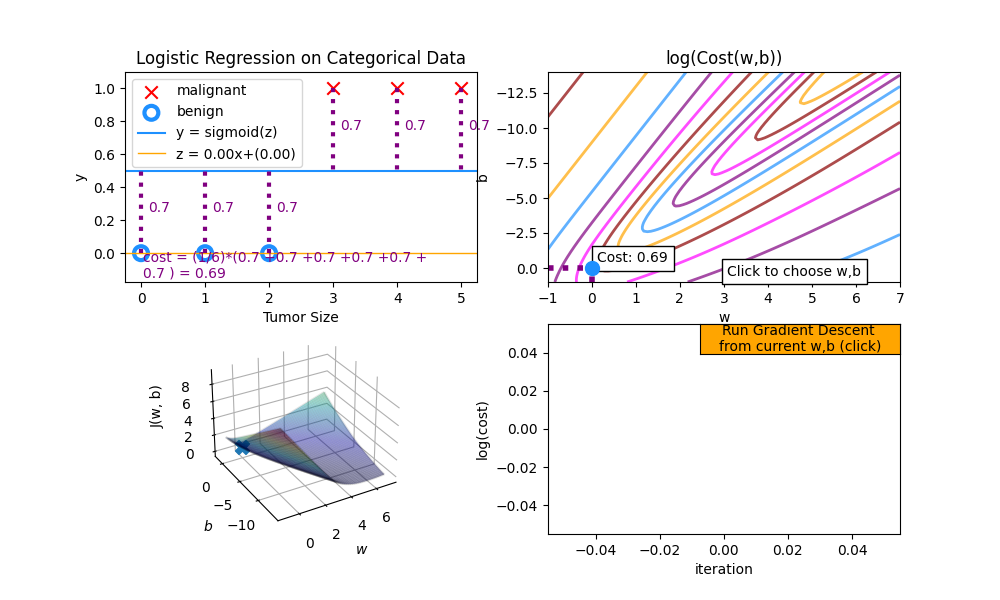

In [24]:
w_range = np.array([-1, 7])
b_range = np.array([1, -14])
quad = plt_quad_logistic( x_train, y_train, w_range, b_range)